In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers , models
from tensorflow.keras.optimizers import Adam

In [274]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [275]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [276]:
Data_Train ="Training"
Data_Test ="Testing"

In [ ]:
def load_data(train, test, img_size =(224, 224), batch_size = 32):
    datagen = ImageDataGenerator(rescale=1./255)

    train_dataset = datagen.flow_from_directory(
        train,
        target_size = img_size,
        batch_size = batch_size,
        class_mode='categorical'
    )
    test_dataset = datagen.flow_from_directory(
        test,
        target_size = img_size,
        batch_size = batch_size,
        class_mode='categorical'
    )

    return train_dataset ,test_dataset


In [278]:
train_data ,test_data = load_data(Data_Train,Data_Test)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


NameError: name 'os' is not defined

In [ ]:
print(train_data.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
class_labels = list(train_data.class_indices.keys())  
class_counts = np.bincount(train_data.classes)  

for label, count in zip(class_labels, class_counts):
    print(f" {label} - {count}")

 glioma - 1321
 meningioma - 1339
 notumor - 1595
 pituitary - 1457


In [ ]:
images, labels = next(train_data)

In [ ]:
labels = np.argmax(labels, axis=1)

In [ ]:
labels

array([2, 2, 1, 0, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 3, 0, 0, 0, 0, 1, 3, 3,
       0, 3, 2, 2, 3, 0, 3, 2, 1, 0], dtype=int64)

In [ ]:
len(class_labels)

4

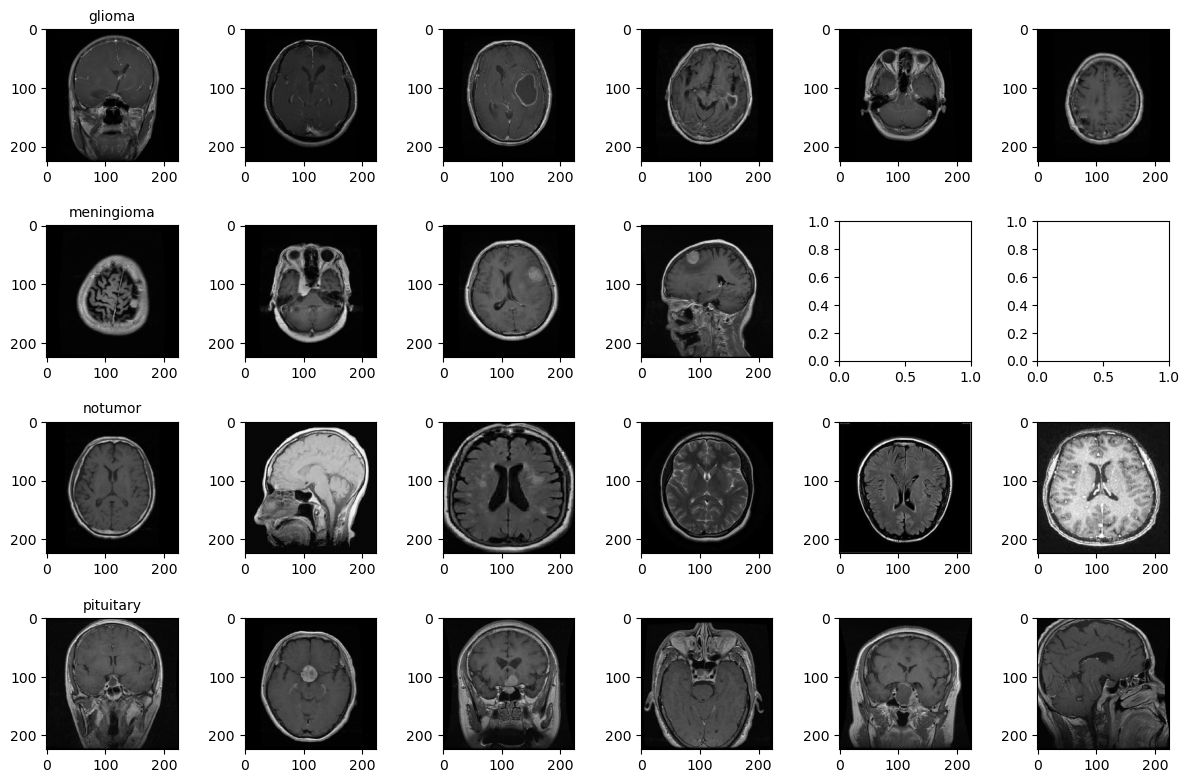

In [ ]:
fig, axes = plt.subplots(len(class_labels), 6, figsize=(12, 8))

for class_idx, class_name in enumerate(class_labels):

    class_images = images[labels == class_idx][:6]
    
    for img_idx, img in enumerate(class_images):
        ax = axes[class_idx, img_idx]
        ax.imshow(img)
            

        if img_idx == 0:
            ax.set_title(class_name, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
def recurrent_residual_conv(input_tensor, filters, t=2):
    x = input_tensor
    for _ in range(t):
        if _ == 0:
            x1 = layers.Conv2D(filters, (3, 3), padding="same", use_bias=False)(x)
            x1 = layers.BatchNormalization()(x1)
            x1 = layers.ReLU()(x1)
        else:
            x1 = layers.Conv2D(filters, (3, 3), padding="same", use_bias=False)(x + x1)
            x1 = layers.BatchNormalization()(x1)
            x1 = layers.ReLU()(x1)
    return x1

def r2_block(input_tensor, filters, t=2):
    """Recurrent residual block for R2U-Net."""
    # Adjust input tensor depth if it does not match the desired filter size
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), padding="same")(input_tensor)
    
    x1 = recurrent_residual_conv(input_tensor, filters, t=t)
    return layers.Add()([input_tensor, x1])

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def FFM(low_level_features, high_level_features, num_filters):
    # Upsampling
    high_level_upsampled = UpSampling2D(size=(2, 2))(high_level_features)
    high_level_upsampled = Conv2D(num_filters, (3, 3), padding="same")(high_level_upsampled)
    high_level_upsampled = BatchNormalization()(high_level_upsampled)
    high_level_upsampled = Activation("relu")(high_level_upsampled)

    # Perform 1x1 convolution on low-level features
    low_level_processed = Conv2D(num_filters, (1, 1), padding="same")(low_level_features)
    low_level_processed = BatchNormalization()(low_level_processed)
    low_level_processed = Activation("relu")(low_level_processed)

    # Combine low-level and high-level features
    combined = Concatenate()([low_level_processed, high_level_upsampled])
    
    # Fuse features
    fused = Conv2D(num_filters, (1, 1), padding="same")(combined)
    fused = BatchNormalization()(fused)
    fused = Activation("relu")(fused)

    return fused

In [ ]:
def build_vgg19_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Load VGG19
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg_s1 = vgg19.get_layer("block1_conv2").output         # (512, 512, 64)
    vgg_s2 = vgg19.get_layer("block2_conv2").output         # (256, 256, 128)
    vgg_s3 = vgg19.get_layer("block3_conv4").output         # (128, 128, 256)
    vgg_s4 = vgg19.get_layer("block4_conv4").output         # (64, 64, 512)
    vgg_s5 = vgg19.get_layer("block5_conv4").output         # (32, 32, 512)

    # R2U-Net Feature Extraction
    r2u_s1 = r2_block(layers.Conv2D(64, (1, 1), padding="same")(inputs), 64, t=2)
    r2u_s2 = r2_block(layers.MaxPooling2D((2, 2))(r2u_s1), 128, t=2)
    r2u_s3 = r2_block(layers.MaxPooling2D((2, 2))(r2u_s2), 256, t=2)
    r2u_s4 = r2_block(layers.MaxPooling2D((2, 2))(r2u_s3), 512, t=2)
    r2u_s5 = r2_block(layers.MaxPooling2D((2, 2))(r2u_s4), 512, t=2)

    # Combine corresponding layers from R2U-Net and ResNetV2
    s1 = layers.Conv2D(64, (1, 1), padding="same")(layers.Concatenate()([r2u_s1, vgg_s1]))
    s2 = layers.Conv2D(128, (1, 1), padding="same")(layers.Concatenate()([r2u_s2, vgg_s2]))
    s3 = layers.Conv2D(256, (1, 1), padding="same")(layers.Concatenate()([r2u_s3, vgg_s3]))
    s4 = layers.Conv2D(512, (1, 1), padding="same")(layers.Concatenate()([r2u_s4, vgg_s4]))
    s5 = layers.Conv2D(512, (1, 1), padding="same")(layers.Concatenate()([r2u_s5, vgg_s5]))
    
    # Apply FFM on each pair of layers
    f1 = FFM(s1, s2, 64)
    f2 = FFM(s2, s3, 128)
    f3 = FFM(s3, s4, 256)
    f4 = FFM(s4, s5, 512)
 
    # Decoder with upsampling
    d1 = decoder_block(s5, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    
    # Final upsampling and combination
    x1 = UpSampling2D(size=(2, 2))(d3)
    combined = Concatenate()([x1, f1])
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(combined)
 
    # Create model
    model = Model(inputs, outputs, name="R2U-ResNet-UNet")
    return model

In [ ]:
input_shape = (512, 512, 3)
model = build_vgg19_unet(input_shape)

In [ ]:
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(256, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Flatten(),
    
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(4, activation='softmax')
# ])


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_404 (Conv2D) │ (None, 224, 224,  │        896 │ input_layer_14[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_405 (Conv2D) │ (None, 224, 224,  │      9,248 │ conv2d_404[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_57    │ (None, 112, 112,  │          0 │ conv2d_405[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_406 (Conv2D) │ (None, 112, 112,  │     18,496 │ max_pooling2d_57… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_407 (Conv2D) │ (None, 112, 112,  │     36,928 │ conv2d_406[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_58    │ (None, 56, 56,    │          0 │ conv2d_407[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_408 (Conv2D) │ (None, 56, 56,    │     73,856 │ max_pooling2d_58… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_409 (Conv2D) │ (None, 56, 56,    │    147,584 │ conv2d_408[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_59    │ (None, 28, 28,    │          0 │ conv2d_409[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_410 (Conv2D) │ (None, 28, 28,    │    295,168 │ max_pooling2d_59… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_411 (Conv2D) │ (None, 28, 28,    │    590,080 │ conv2d_410[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_60    │ (None, 14, 14,    │          0 │ conv2d_411[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_412 (Conv2D) │ (None, 14, 14,    │  1,180,160 │ max_pooling2d_60… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_413 (Conv2D) │ (None, 14, 14,    │  2,359,808 │ conv2d_412[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_44 │ (None, 28, 28,    │  1,179,904 │ conv2d_413[0][0]  │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_124     │ (None, 28, 28,    │          0 │ conv2d_transpose

 Total params: 8,630,596 (32.92 MB)

 Trainable params: 8,630,596 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    batch_size=32,
)


Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 4), output.shape=(None, 224, 224, 4)

In [ ]:
model.summary()


In [ ]:
history = model.history.history

In [ ]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

In [ ]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,      
    rotation_range=20,   
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,      
    zoom_range=0.2,       
    horizontal_flip=True, 
    fill_mode='nearest'   
)

test_datagen = ImageDataGenerator(rescale=1./255)  


train_data = train_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20, 
    batch_size=32
)


In [ ]:
history = model.history.history

In [ ]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

In [ ]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
